In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from feature_engineering import rsi, wwma, atr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)


In [2]:
#load data
ticker = 'APPLE'
cur_dir = Path(os.getcwd())
parent_path = cur_dir.parent
f_path = parent_path / 'data/{}.csv'.format(ticker)
df=pd.read_csv(f_path)

In [3]:
#create a dataframe with only 'Close' column
data = df.filter(['Close', 'Volume'])
temp = df.filter(['Close'])

#have to change the index to int temporarly for the rsi method
date_index = data.index
data.index = np.arange(0,df.shape[0])

#compute RSI and keep only Close and final RSI column
data =  rsi(data, 14).filter(['Close','Volume','rsi'])

#reset index to Date format
data.index = date_index

#slice the first 14 NaN values of RSI
data = data[14:]

num_features =data.shape[1]

training_data_len = math.ceil( data.shape[0] *.8) 
train_Data = data[0:training_data_len]
y_train = train_Data['Close'][1:] #shift y by one because we wan to predict time t+1
X_train = data[0:train_Data.shape[0]-1] #remove last row so y and x have the same length

#validation =
val_data = data[training_data_len:]
y_val = val_data['Close'][1:] #shift y by one because we wan to predict time t+1
X_val = val_data[0:val_data.shape[0]-1] #remove last row so y and x have the same length
#print(X_train.head(), y_train.head())

In [4]:
#fit linear regression with training data
reg = LinearRegression().fit(X_train, y_train)

#use predict function with validation data on LR
y_hat_val = reg.predict(X_val)

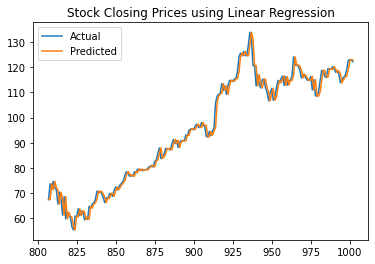

In [5]:
#plot the given stocks data and the predicted data from the validation data
def plot_linear_svr(val_data,val_y, y_hat_val):
    plt.plot(val_data.tail(val_y.shape[0]).index,val_y,label = 'Actual')
    plt.plot(val_data.tail(val_y.shape[0]).index,y_hat_val,label = 'Predicted')
    plt.title('Stock Closing Prices using Linear Regression')
    plt.legend(loc='upper left')
    
    
#plot code    
plot_linear_svr(val_data,y_val, y_hat_val)

In [6]:
forecasted_loss = mean_squared_error(y_hat_val,y_val.to_numpy())
print('MSE Loss for forecasted value(s): ', forecasted_loss)

MSE Loss for forecasted value(s):  7.6321253175320445


In [7]:
y_actual = val_data['Close'].tail(y_val.shape[0]).to_numpy()
right_direction = 0
for day in range(1,len(y_hat_val)):
    if y_hat_val[day] < y_actual[day-1] and  y_actual[day] < y_actual[day-1]:
        right_direction += 1
    if y_hat_val[day] > y_actual[day-1] and  y_actual[day] > y_actual[day-1]:
        right_direction += 1
print('The percentage the model predicted the price in the right direction is: ', right_direction/len(y_hat_val)*100)

The percentage the model predicted the price in the right direction is:  51.53061224489795
